#Pretrained CNN (VGG-16)

##Pretrained CNN (VGG-16)
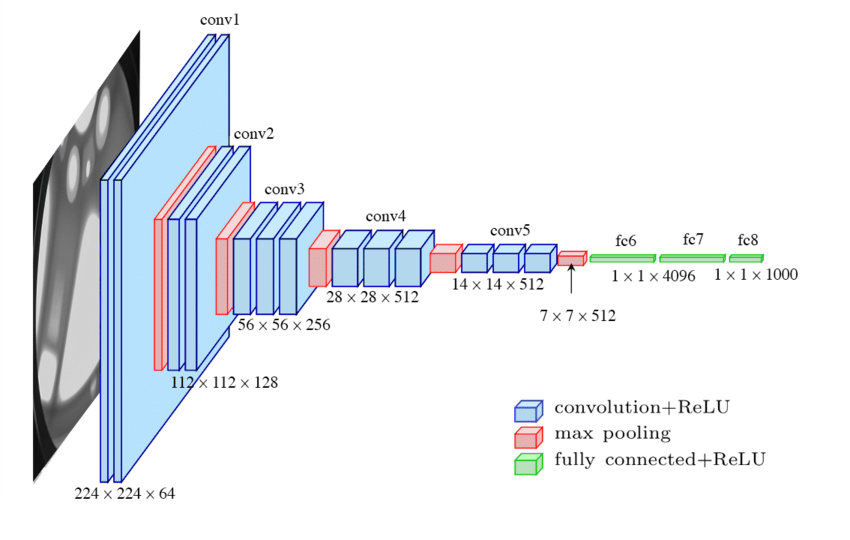

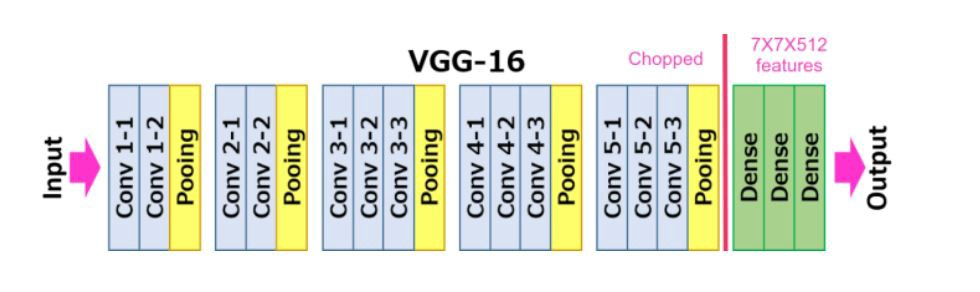


VGG-16 model produce very high accuracy of the model near to 92.7% whether you have a huge amount of data



IMREAD_COLOR: It specifies to load a color image. Any transparency of image will be neglected. It is the default flag. Alternatively, we can pass integer value 1 for this flag.

In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16


print(os.listdir("images/"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 1024 #Resize images (height  = X, width = Y)
SIZE_Y = 996

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("images/train_images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("images/train_masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 


#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', 
                  include_top=False,#that means do not import dense layers 
                  input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

print("The summary of the VGG-16 model")    
VGG_model.summary()  #Trainable parameters will be 0


In [ ]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

#Now, let us apply feature extractor to our training data
# That is features extractor of our traning dataset
# new_model_prediction=new_model.predict(X_train)# size of train images=(8,1024,996,3)
features=new_model.predict(X_train)# size of train images=(8,1024,996,3)

#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels
comatibale for random forest 
# X=(8,1024,996,64)===>(845352,64) colab all shape becoz random forest takes this in such way that  and 64 =most of the columns
#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
# Plot features to views them
# size of the features=(8,1024,996,64)
# that means we have 64 feaures that are going into random forest 
# visualize how to features looks like and map out all the features
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0] # drop the dataset all the pixels which have data values zeros
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

#Save model for future use
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

#Test on a different image
#READ EXTERNAL IMAGE...
# Use open CV to read it
test_img = cv2.imread('images/test_images/Sandstone_Versa0360.tif', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)# if you need then expand otherwise it's ok

# EXtract the features or predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3]) # that basically combine two columns and colap this 

prediction = loaded_model.predict(X_test_feature)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape) # after then reshape the image into 2D images
plt.imshow(prediction_image, cmap='gray')
plt.imsave('images/test_images/360_segmented.jpg', prediction_image, cmap='gray')
